# Pre-processing and Features Selection

## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load the dataset
file_path = '/home/diego_nbotelho/code/diegonbotelho/f1-tire-prediction/raw_data/df_all_races.csv'
# file_path = '/home/mgasilva/code/diegonbotelho/f1-tire-prediction/raw_data/df_all_races.csv'
all_races_df = pd.read_csv(file_path)

In [3]:
all_races_df.describe()

,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,...,TrackStatus,Position,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,WindSpeed,Event_Year,Delta_Lap
count,67079.000000,66075.000000,67079.000000,67079.000000,65642.000000,66957.000000,66849.000000,65481.000000,66957.000000,66849.000000,...,67079.000000,66970.000000,67079.000000,67079.000000,67079.000000,67079.000000,67079.000000,67079.000000,67079.000000,67079.000000
mean,27.442135,90.577693,31.069351,2.145783,28.190974,35.667639,26.815196,6766.215976,6754.194187,6779.226838,...,11.965921,9.735165,24.300109,53.229908,980.563155,35.875177,185.198527,1.725370,2023.014461,0.276384
std,22.988637,40.030159,18.745217,0.989806,7.937653,8.444506,6.796704,2083.811745,2107.921948,2104.953791,...,119.229446,5.399382,4.457787,17.999444,57.804645,7.540341,99.593720,1.065814,0.815357,45.910401
min,1.000000,67.012000,1.000000,1.000000,16.835000,17.488000,16.913000,377.920000,312.070000,349.775000,...,1.000000,1.000000,15.700000,5.000000,778.500000,18.100000,0.000000,0.000000,2022.000000,-2414.122000
25%,11.000000,79.805000,15.000000,1.000000,21.780250,30.205000,21.948000,5172.700000,5138.387000,5166.002000,...,1.000000,5.000000,20.800000,38.000000,971.000000,30.100000,119.000000,1.000000,2022.000000,-0.316000
50%,21.000000,86.640000,30.000000,2.000000,28.833000,33.283000,25.452000,6609.799000,6596.730000,6622.602000,...,1.000000,10.000000,24.000000,56.000000,1007.700000,35.000000,181.000000,1.500000,2023.000000,0.000000
75%,44.000000,97.177000,46.000000,3.000000,31.740750,41.984000,30.168000,8094.164000,8104.687000,8128.365000,...,1.000000,14.000000,27.300000,65.000000,1013.400000,42.600000,275.000000,2.200000,2024.000000,0.304000
max,81.000000,2526.253000,78.000000,8.000000,98.794000,90.308000,99.740000,15028.032000,15071.178000,15109.601000,...,16724.000000,20.000000,37.200000,92.000000,1020.900000,51.300000,359.000000,6.200000,2024.000000,2433.269000


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', None)
all_races_df.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Event_Year,GrandPrix,Delta_Lap
0,0 days 01:04:15.340000,VER,1,100.236,1.0,1.0,NaN,NaN,NaN,42.325,24.389,NaN,3831.046,3855.427,230.0,254.0,274.0,250.0,False,SOFT,4.0,False,Red Bull Racing,0 days 01:02:34.872000,2022-03-20 15:03:34.889,1,2.0,False,NaN,False,False,23.9,25.0,1010.2,False,29.1,20,0.5,2022,Bahrain,0.000
1,0 days 01:05:53.220000,VER,1,97.880,2.0,1.0,NaN,NaN,31.285,42.269,24.326,3886.662,3928.931,3953.257,NaN,252.0,276.0,296.0,True,SOFT,5.0,False,Red Bull Racing,0 days 01:04:15.340000,2022-03-20 15:05:15.357,1,2.0,False,NaN,False,True,23.8,26.0,1010.4,False,29.0,357,0.5,2022,Bahrain,-2.356
2,0 days 01:07:31.577000,VER,1,98.357,3.0,1.0,NaN,NaN,31.499,42.474,24.384,3984.756,4027.230,4051.614,229.0,254.0,276.0,294.0,False,SOFT,6.0,False,Red Bull Racing,0 days 01:05:53.220000,2022-03-20 15:06:53.237,1,2.0,False,NaN,False,True,23.8,27.0,1010.4,False,29.0,12,0.5,2022,Bahrain,0.477
3,0 days 01:09:10.143000,VER,1,98.566,4.0,1.0,NaN,NaN,31.342,42.674,24.550,4082.956,4125.630,4150.180,231.0,250.0,276.0,297.0,False,SOFT,7.0,False,Red Bull Racing,0 days 01:07:31.577000,2022-03-20 15:08:31.594,1,2.0,False,NaN,False,True,23.8,29.0,1010.4,False,28.7,12,0.4,2022,Bahrain,0.209
4,0 days 01:10:49.020000,VER,1,98.877,5.0,1.0,NaN,NaN,31.498,42.854,24.525,4181.678,4224.532,4249.057,229.0,256.0,276.0,293.0,False,SOFT,8.0,False,Red Bull Racing,0 days 01:09:10.143000,2022-03-20 15:10:10.160,1,2.0,False,NaN,False,True,23.8,33.0,1010.4,False,28.5,316,0.4,2022,Bahrain,0.311


In [5]:
# Display basic info
print("Dataset shape:", all_races_df.shape)

Dataset shape: (67079, 41)


In [6]:
# Missing Data Analysis
print("Missing data per column:")
print(all_races_df.isnull().sum())

Missing data per column:
Time                      0
Driver                    0
DriverNumber              0
LapTime                1004
LapNumber                 0
Stint                     0
PitOutTime            64732
PitInTime             64708
Sector1Time            1437
Sector2Time             122
Sector3Time             230
Sector1SessionTime     1598
Sector2SessionTime      122
Sector3SessionTime      230
SpeedI1               10095
SpeedI2                 119
SpeedFL                2483
SpeedST                6014
IsPersonalBest           80
Compound                  0
TyreLife                  0
FreshTyre                 0
Team                      0
LapStartTime              0
LapStartDate             80
TrackStatus               0
Position                109
Deleted                   0
DeletedReason         66192
FastF1Generated           0
IsAccurate                0
AirTemp                   0
Humidity                  0
Pressure                  0
Rainfall               

In [7]:
# Exclusion of features that are not necessary
columns_to_remove = [
    'Time',
    'DriverNumber',
    'PitOutTime',
    'PitInTime',
    'Sector1SessionTime',
    'Sector2SessionTime',
    'Sector3SessionTime',
    'SpeedI1',
    'SpeedI2',
    'SpeedFL',
    'SpeedST',
    'IsPersonalBest',
    'FreshTyre',
    'Team',
    'LapStartTime',
    'LapStartDate',
    'Deleted',
    'DeletedReason',
    'FastF1Generated',
    'IsAccurate',
    'WindDirection',
    'WindSpeed',
    'Delta_Lap'
]

new_df = all_races_df.drop(columns=columns_to_remove)
new_df.head()

,Driver,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Compound,TyreLife,TrackStatus,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,Event_Year,GrandPrix
0,VER,100.236,1.0,1.0,NaN,42.325,24.389,SOFT,4.0,1,2.0,23.9,25.0,1010.2,False,29.1,2022,Bahrain
1,VER,97.880,2.0,1.0,31.285,42.269,24.326,SOFT,5.0,1,2.0,23.8,26.0,1010.4,False,29.0,2022,Bahrain
2,VER,98.357,3.0,1.0,31.499,42.474,24.384,SOFT,6.0,1,2.0,23.8,27.0,1010.4,False,29.0,2022,Bahrain
3,VER,98.566,4.0,1.0,31.342,42.674,24.550,SOFT,7.0,1,2.0,23.8,29.0,1010.4,False,28.7,2022,Bahrain
4,VER,98.877,5.0,1.0,31.498,42.854,24.525,SOFT,8.0,1,2.0,23.8,33.0,1010.4,False,28.5,2022,Bahrain


In [8]:
# Display basic info
print("Dataset shape:", new_df.shape)

Dataset shape: (67079, 18)


In [9]:
# Missing Data Analysis
print("Missing data per column:")
print(new_df.isnull().sum())

Missing data per column:
Driver            0
LapTime        1004
LapNumber         0
Stint             0
Sector1Time    1437
Sector2Time     122
Sector3Time     230
Compound          0
TyreLife          0
TrackStatus       0
Position        109
AirTemp           0
Humidity          0
Pressure          0
Rainfall          0
TrackTemp         0
Event_Year        0
GrandPrix         0
dtype: int64


In [10]:
new_df = new_df.dropna(subset=['Position'])

In [11]:
# Missing Data Analysis
print("Missing data per column:")
print(new_df.isnull().sum())

Missing data per column:
Driver            0
LapTime         895
LapNumber         0
Stint             0
Sector1Time    1328
Sector2Time      13
Sector3Time     121
Compound          0
TyreLife          0
TrackStatus       0
Position          0
AirTemp           0
Humidity          0
Pressure          0
Rainfall          0
TrackTemp         0
Event_Year        0
GrandPrix         0
dtype: int64


In [12]:
# Verify duplicates
print("\nNumber of duplicates:")
print(new_df.duplicated().sum())


Number of duplicates:
0


In [13]:
# Strategy for missing values

# Fill null values in numeric columns with the median
numerical_columns = new_df.select_dtypes(include=[np.number]).columns
new_df.loc[:, numerical_columns] = new_df[numerical_columns].fillna(new_df[numerical_columns].median())

# Verify missing values after treatment
print("\nMissing values after treatment:")
print(new_df.isnull().sum())


Missing values after treatment:
Driver         0
LapTime        0
LapNumber      0
Stint          0
Sector1Time    0
Sector2Time    0
Sector3Time    0
Compound       0
TyreLife       0
TrackStatus    0
Position       0
AirTemp        0
Humidity       0
Pressure       0
Rainfall       0
TrackTemp      0
Event_Year     0
GrandPrix      0
dtype: int64


In [14]:
new_df['Compound'].value_counts()

Compound
HARD            29837
MEDIUM          23344
SOFT             8669
INTERMEDIATE     4903
WET               217
Name: count, dtype: int64

## 2 Scale the features

In [15]:
# Numerical variables
numerical_features = [
    'LapTime',            # Lap time in seconds
    'TyreLife',           # Tyre life
    'AirTemp',            # Air temperature
    'TrackTemp',          # Track temperature
    'WindSpeed',          # Wind speed
    'SpeedI1',            # Speed in the first sector
    'SpeedI2',            # Speed in the second sector
    'SpeedFL',            # Speed on the main straight
    'SpeedST',            # Speed in the timing sector
    'Position',           # Position in the race
    'Humidity',           # Relative humidity of the air
    'Pressure',           # Atmospheric pressure
    'WindDirection',      # Wind direction
    'Sector1Time',        # Time in sector 1
    'Sector2Time',        # Time in sector 2
    'Sector3Time',        # Time in sector 3
    'LapNumber',          # Number of the lap
    'Delta_Lap'           # time difference between two consecutives laps for each pilot
]

In [16]:
# Categorical variables
categorical_features = [
    'Compound',    # Tire type (SOFT, MEDIUM, HARD)
    'TrackStatus', # Track status (green flag, yellow flag, etc.)
    'FreshTyre',   # True or false
    'Rainfall'     # True or false
]

In [17]:
new_df.describe()

,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,TyreLife,TrackStatus,Position,AirTemp,Humidity,Pressure,TrackTemp,Event_Year
count,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000,66970.000000
mean,90.525069,31.072704,2.146036,28.203706,35.667176,26.812733,14.805405,11.563536,9.735165,24.301000,53.226594,980.547689,35.876464,2023.014648
std,39.764341,18.737846,0.989543,7.859066,8.443752,6.790808,10.825625,99.611912,5.399382,4.457512,18.001104,57.816682,7.539795,0.815441
min,67.012000,1.000000,1.000000,16.835000,17.488000,16.913000,1.000000,1.000000,1.000000,15.700000,5.000000,778.500000,18.100000,2022.000000
25%,79.952000,15.000000,1.000000,21.894250,30.205000,21.952000,6.000000,1.000000,5.000000,20.800000,38.000000,971.000000,30.100000,2022.000000
50%,86.640000,30.000000,2.000000,28.833000,33.283000,25.452000,13.000000,1.000000,10.000000,24.000000,56.000000,1007.700000,35.000000,2023.000000
75%,96.966000,46.000000,3.000000,31.670000,41.981000,30.160750,21.000000,1.000000,14.000000,27.300000,65.000000,1013.400000,42.600000,2024.000000
max,2526.253000,78.000000,8.000000,98.794000,90.308000,99.740000,78.000000,2671.000000,20.000000,37.200000,92.000000,1020.900000,51.300000,2024.000000


In [18]:
# Remove Outliers from LapTime

# Calculate Q1 and Q3
Q1 = new_df['LapTime'].quantile(0.25)
Q3 = new_df['LapTime'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
new_df = new_df[(new_df['LapTime'] >= lower_bound) & (new_df['LapTime'] <= upper_bound)]

new_df.describe()

# # Remove Outliers from Pressure

# # Calculate Q1 and Q3
# Q1 = new_df['Pressure'].quantile(0.25)
# Q3 = new_df['Pressure'].quantile(0.75)

# # Calculate the IQR
# IQR = Q3 - Q1

# # Define boundaries for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out outliers
# new_df = new_df[(new_df['Pressure'] >= lower_bound) & (new_df['Pressure'] <= upper_bound)]

# new_df.describe()

,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,TyreLife,TrackStatus,Position,AirTemp,Humidity,Pressure,TrackTemp,Event_Year
count,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000
mean,88.496836,31.370353,2.150304,27.722779,35.232767,26.350526,15.040187,9.188084,9.712088,24.330235,52.941686,980.199280,35.978367,2023.021644
std,11.872032,18.691923,0.984997,7.235846,8.030571,6.095555,10.810616,86.587111,5.396455,4.467978,17.940501,57.972911,7.523487,0.814194
min,67.012000,1.000000,1.000000,16.835000,17.488000,16.913000,1.000000,1.000000,1.000000,15.700000,5.000000,778.500000,18.100000,2022.000000
25%,79.589750,15.000000,1.000000,21.723000,30.138000,21.891000,7.000000,1.000000,5.000000,20.800000,37.000000,970.900000,30.300000,2022.000000
50%,86.308000,30.000000,2.000000,28.771000,32.985500,25.312000,13.000000,1.000000,10.000000,24.100000,55.000000,1007.700000,35.100000,2023.000000
75%,95.589000,46.000000,3.000000,31.424000,40.715000,29.779000,21.000000,1.000000,14.000000,27.500000,65.000000,1013.400000,42.600000,2024.000000
max,122.476000,78.000000,8.000000,98.794000,87.765000,99.740000,78.000000,2671.000000,20.000000,37.200000,92.000000,1020.900000,51.300000,2024.000000


In [19]:
# Assuming your DataFrame is named df:
# First, calculate the max lap number for each unique GrandPrix/Event_Year combination
new_df['LapPct'] = new_df['LapNumber'] / new_df.groupby(['Event_Year', 'GrandPrix'])['LapNumber'].transform('max')

# Display a sample
new_df[['Driver','LapNumber','LapPct','Event_Year','GrandPrix']].head(200)

,Driver,LapNumber,LapPct,Event_Year,GrandPrix
0,VER,1.0,0.017544,2022,Bahrain
1,VER,2.0,0.035088,2022,Bahrain
2,VER,3.0,0.052632,2022,Bahrain
3,VER,4.0,0.070175,2022,Bahrain
4,VER,5.0,0.087719,2022,Bahrain
...,...,...,...,...,...
210,ALO,55.0,0.964912,2022,Bahrain
211,ALO,56.0,0.982456,2022,Bahrain
212,ALO,57.0,1.000000,2022,Bahrain
213,LEC,1.0,0.017544,2022,Bahrain


In [20]:
# # Colummns for Robust Scaler
# columns_for_robust_scaler = ['LapTime',
#                              'TyreLife',
#                              'AirTemp',
#                              'TrackTemp',
#                              'Humidity',
#                              'Pressure',
#                              'Sector1Time',
#                              'Sector2Time',
#                              'Sector3Time']

# # Colummns for MinMax Scaler
# columns_for_minmax_scaler = ['Position', 'LapNumber']

In [21]:
# Build the pipeline

# Distribution
distribution_pipeline = Pipeline([
    ('Median_Imputer', SimpleImputer(strategy = 'median')),
    ('Robust_Scaler', RobustScaler())
])

# Range
range_pipeline = Pipeline([
    ('Median_Imputer', SimpleImputer(strategy = 'median')),
    ('Minmax_Scaler', MinMaxScaler())
])

# Normalization
normal_pipeline = Pipeline([
    ('Median_imputer', SimpleImputer(strategy = 'median')),
    ('Standard_Scaler', StandardScaler())
])

# Scaling
scaling_pipeline = Pipeline([
    ('Median_imputer', SimpleImputer(strategy = 'median')),
    ('robust_scaler', RobustScaler()),
    ('minmax_scaler', MinMaxScaler(feature_range=(-1, 1)))  # Customize range here
])

In [22]:
# Transform
numeric_preprocessor = ColumnTransformer([
    ('robust_transformer', distribution_pipeline, ['LapTime',
                                                     'TyreLife',
                                                     'AirTemp',
                                                     'TrackTemp',
                                                     'Humidity']),
    ('range_transformer', range_pipeline, ['Position']),
    ('robust_and_scale', scaling_pipeline, ['Pressure', 'Sector1Time', 'Sector2Time', 'Sector3Time']),
    ('passthrough_cols', 'passthrough', ['LapPct']) 
])

# Visualizing Pipelines
numeric_preprocessor

ColumnTransformer(transformers=[('robust_transformer',
                                 Pipeline(steps=[('Median_Imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('Robust_Scaler',
                                                  RobustScaler())]),
                                 ['LapTime', 'TyreLife', 'AirTemp', 'TrackTemp',
                                  'Humidity']),
                                ('range_transformer',
                                 Pipeline(steps=[('Median_Imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('Minmax_Scaler',
                                                  MinMaxScaler())]),
                                 ['Position']),
                                ('robust_and_scale',
                                 Pipeline(steps=[('Median_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler()),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)))]),
                                 ['Pressure', 'Sector1Time', 'Sector2Time',
                                  'Sector3Time']),
                                ('passthrough_cols', 'passthrough',
                                 ['LapPct'])])

In [23]:
transformed_dataframe = pd.DataFrame(numeric_preprocessor.fit_transform(new_df), columns = numeric_preprocessor.get_feature_names_out())

In [24]:
transformed_dataframe.describe()

,robust_transformer__LapTime,robust_transformer__TyreLife,robust_transformer__AirTemp,robust_transformer__TrackTemp,robust_transformer__Humidity,range_transformer__Position,robust_and_scale__Pressure,robust_and_scale__Sector1Time,robust_and_scale__Sector2Time,robust_and_scale__Sector3Time,passthrough_cols__LapPct
count,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000
mean,0.136809,0.145728,0.034363,0.071412,-0.073511,0.458531,0.664185,-0.734312,-0.495005,-0.772115,0.499477
std,0.742037,0.772187,0.666862,0.611666,0.640732,0.284024,0.478324,0.176572,0.228541,0.147188,0.285610
min,-1.206057,-0.857143,-1.253731,-1.382114,-1.785714,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.012821
25%,-0.419910,-0.428571,-0.492537,-0.390244,-0.642857,0.210526,0.587459,-0.880721,-0.639996,-0.879798,0.253521
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.473684,0.891089,-0.708732,-0.558960,-0.797192,0.492958
75%,0.580090,0.571429,0.507463,0.609756,0.357143,0.684211,0.938119,-0.643993,-0.338987,-0.689328,0.745098
max,2.260606,4.642857,1.955224,1.317073,1.321429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


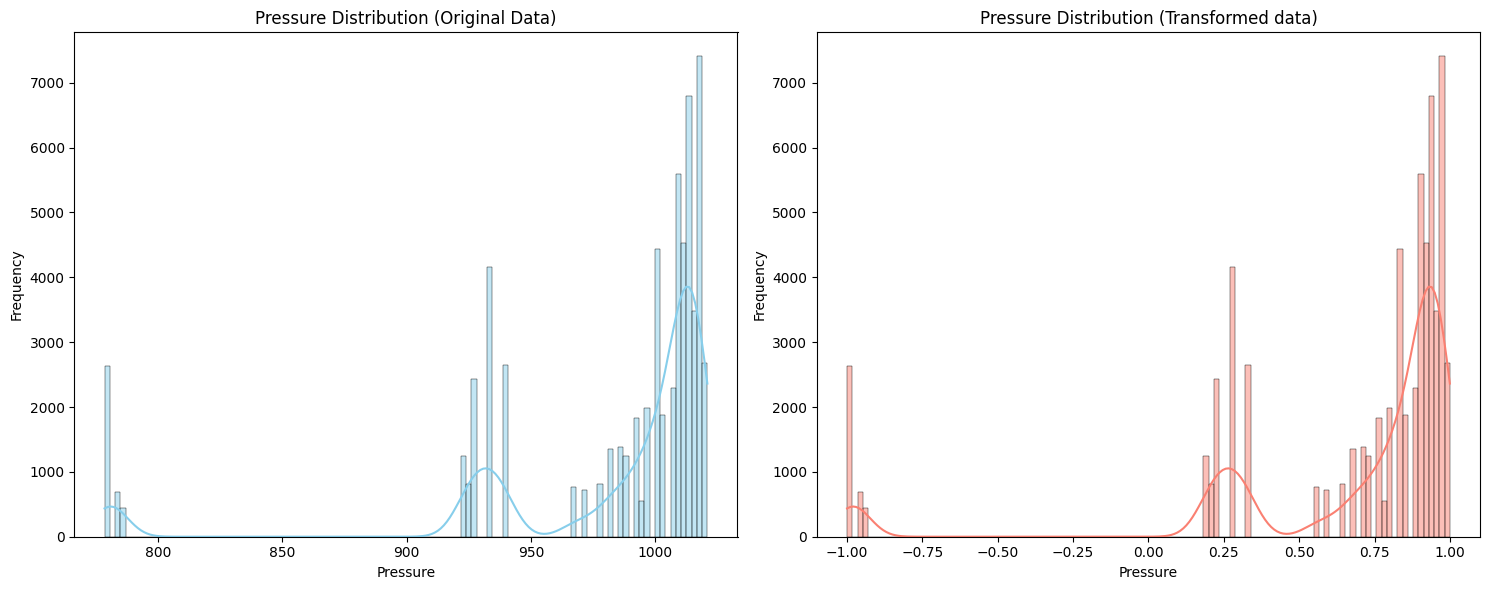

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for original data
sns.histplot(new_df['Pressure'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Pressure Distribution (Original Data)')
axes[0].set_xlabel('Pressure')
axes[0].set_ylabel('Frequency')

# Histogram for transformed data
sns.histplot(transformed_dataframe['robust_and_scale__Pressure'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Pressure Distribution (Transformed data)')
axes[1].set_xlabel('Pressure')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [26]:
transformed_dataframe.describe()

,robust_transformer__LapTime,robust_transformer__TyreLife,robust_transformer__AirTemp,robust_transformer__TrackTemp,robust_transformer__Humidity,range_transformer__Position,robust_and_scale__Pressure,robust_and_scale__Sector1Time,robust_and_scale__Sector2Time,robust_and_scale__Sector3Time,passthrough_cols__LapPct
count,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000,64822.000000
mean,0.136809,0.145728,0.034363,0.071412,-0.073511,0.458531,0.664185,-0.734312,-0.495005,-0.772115,0.499477
std,0.742037,0.772187,0.666862,0.611666,0.640732,0.284024,0.478324,0.176572,0.228541,0.147188,0.285610
min,-1.206057,-0.857143,-1.253731,-1.382114,-1.785714,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.012821
25%,-0.419910,-0.428571,-0.492537,-0.390244,-0.642857,0.210526,0.587459,-0.880721,-0.639996,-0.879798,0.253521
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.473684,0.891089,-0.708732,-0.558960,-0.797192,0.492958
75%,0.580090,0.571429,0.507463,0.609756,0.357143,0.684211,0.938119,-0.643993,-0.338987,-0.689328,0.745098
max,2.260606,4.642857,1.955224,1.317073,1.321429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Encode features (OneHotEnconder)

In [27]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(new_df[['Driver']])

new_df[ohe.get_feature_names_out()] = ohe.transform(new_df[['Driver']])

new_df = new_df.drop(columns=["Driver"])
new_df.head(3)

,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Compound,TyreLife,TrackStatus,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,Event_Year,GrandPrix,LapPct,Driver_ALB,Driver_ALO,Driver_BEA,Driver_BOT,Driver_COL,Driver_DEV,Driver_DOO,Driver_GAS,Driver_HAM,Driver_HUL,Driver_LAT,Driver_LAW,Driver_LEC,Driver_MAG,Driver_MSC,Driver_NOR,Driver_OCO,Driver_PER,Driver_PIA,Driver_RIC,Driver_RUS,Driver_SAI,Driver_SAR,Driver_STR,Driver_TSU,Driver_VER,Driver_VET,Driver_ZHO
0,100.236,1.0,1.0,28.833,42.325,24.389,SOFT,4.0,1,2.0,23.9,25.0,1010.2,False,29.1,2022,Bahrain,0.017544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,97.880,2.0,1.0,31.285,42.269,24.326,SOFT,5.0,1,2.0,23.8,26.0,1010.4,False,29.0,2022,Bahrain,0.035088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,98.357,3.0,1.0,31.499,42.474,24.384,SOFT,6.0,1,2.0,23.8,27.0,1010.4,False,29.0,2022,Bahrain,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(new_df[['GrandPrix']])

new_df[ohe.get_feature_names_out()] = ohe.transform(new_df[['GrandPrix']])

new_df = new_df.drop(columns=["GrandPrix"])
new_df.head(3)

,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Compound,TyreLife,TrackStatus,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,Event_Year,LapPct,Driver_ALB,Driver_ALO,Driver_BEA,Driver_BOT,Driver_COL,Driver_DEV,Driver_DOO,Driver_GAS,Driver_HAM,Driver_HUL,Driver_LAT,Driver_LAW,Driver_LEC,Driver_MAG,Driver_MSC,Driver_NOR,Driver_OCO,Driver_PER,Driver_PIA,Driver_RIC,Driver_RUS,Driver_SAI,Driver_SAR,Driver_STR,Driver_TSU,Driver_VER,Driver_VET,Driver_ZHO,GrandPrix_Abu Dhabi,GrandPrix_Australia,GrandPrix_Austria,GrandPrix_Azerbaijan,GrandPrix_Bahrain,GrandPrix_Belgium,GrandPrix_Brazil,GrandPrix_Canada,GrandPrix_Great Britain,GrandPrix_Hungary,GrandPrix_Italy,GrandPrix_Japan,GrandPrix_Mexico,GrandPrix_Miami,GrandPrix_Monaco,GrandPrix_Netherlands,GrandPrix_Saudi Arabia,GrandPrix_Singapore,GrandPrix_Spain,GrandPrix_USA
0,100.236,1.0,1.0,28.833,42.325,24.389,SOFT,4.0,1,2.0,23.9,25.0,1010.2,False,29.1,2022,0.017544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,97.880,2.0,1.0,31.285,42.269,24.326,SOFT,5.0,1,2.0,23.8,26.0,1010.4,False,29.0,2022,0.035088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,98.357,3.0,1.0,31.499,42.474,24.384,SOFT,6.0,1,2.0,23.8,27.0,1010.4,False,29.0,2022,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(new_df[['Compound']])

new_df[ohe.get_feature_names_out()] = ohe.transform(new_df[['Compound']])

new_df = new_df.drop(columns=["Compound"])
new_df.head(3)

,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,TyreLife,TrackStatus,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,Event_Year,LapPct,Driver_ALB,Driver_ALO,Driver_BEA,Driver_BOT,Driver_COL,Driver_DEV,Driver_DOO,Driver_GAS,Driver_HAM,Driver_HUL,Driver_LAT,Driver_LAW,Driver_LEC,Driver_MAG,Driver_MSC,Driver_NOR,Driver_OCO,Driver_PER,Driver_PIA,Driver_RIC,Driver_RUS,Driver_SAI,Driver_SAR,Driver_STR,Driver_TSU,Driver_VER,Driver_VET,Driver_ZHO,GrandPrix_Abu Dhabi,GrandPrix_Australia,GrandPrix_Austria,GrandPrix_Azerbaijan,GrandPrix_Bahrain,GrandPrix_Belgium,GrandPrix_Brazil,GrandPrix_Canada,GrandPrix_Great Britain,GrandPrix_Hungary,GrandPrix_Italy,GrandPrix_Japan,GrandPrix_Mexico,GrandPrix_Miami,GrandPrix_Monaco,GrandPrix_Netherlands,GrandPrix_Saudi Arabia,GrandPrix_Singapore,GrandPrix_Spain,GrandPrix_USA,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET
0,100.236,1.0,1.0,28.833,42.325,24.389,4.0,1,2.0,23.9,25.0,1010.2,False,29.1,2022,0.017544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,97.880,2.0,1.0,31.285,42.269,24.326,5.0,1,2.0,23.8,26.0,1010.4,False,29.0,2022,0.035088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,98.357,3.0,1.0,31.499,42.474,24.384,6.0,1,2.0,23.8,27.0,1010.4,False,29.0,2022,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
new_df

,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,TyreLife,TrackStatus,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,Event_Year,LapPct,Driver_ALB,Driver_ALO,Driver_BEA,Driver_BOT,Driver_COL,Driver_DEV,Driver_DOO,Driver_GAS,Driver_HAM,Driver_HUL,Driver_LAT,Driver_LAW,Driver_LEC,Driver_MAG,Driver_MSC,Driver_NOR,Driver_OCO,Driver_PER,Driver_PIA,Driver_RIC,Driver_RUS,Driver_SAI,Driver_SAR,Driver_STR,Driver_TSU,Driver_VER,Driver_VET,Driver_ZHO,GrandPrix_Abu Dhabi,GrandPrix_Australia,GrandPrix_Austria,GrandPrix_Azerbaijan,GrandPrix_Bahrain,GrandPrix_Belgium,GrandPrix_Brazil,GrandPrix_Canada,GrandPrix_Great Britain,GrandPrix_Hungary,GrandPrix_Italy,GrandPrix_Japan,GrandPrix_Mexico,GrandPrix_Miami,GrandPrix_Monaco,GrandPrix_Netherlands,GrandPrix_Saudi Arabia,GrandPrix_Singapore,GrandPrix_Spain,GrandPrix_USA,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET
0,100.236,1.0,1.0,28.833,42.325,24.389,4.0,1,2.0,23.9,25.0,1010.2,False,29.1,2022,0.017544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,97.880,2.0,1.0,31.285,42.269,24.326,5.0,1,2.0,23.8,26.0,1010.4,False,29.0,2022,0.035088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,98.357,3.0,1.0,31.499,42.474,24.384,6.0,1,2.0,23.8,27.0,1010.4,False,29.0,2022,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,98.566,4.0,1.0,31.342,42.674,24.550,7.0,1,2.0,23.8,29.0,1010.4,False,28.7,2022,0.070175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,98.877,5.0,1.0,31.498,42.854,24.525,8.0,1,2.0,23.8,33.0,1010.4,False,28.5,2022,0.087719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67074,87.731,54.0,3.0,17.591,38.078,32.062,22.0,1,10.0,25.9,60.0,1017.8,False,29.3,2024,0.931034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67075,87.781,55.0,3.0,17.639,38.014,32.128,23.0,1,10.0,25.9,60.0,1017.9,False,29.3,2024,0.948276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67076,87.816,56.0,3.0,17.603,38.000,32.213,24.0,1,10.0,25.9,60.0,1018.0,False,29.4,2024,0.965517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67077,88.554,57.0,3.0,17.650,38.546,32.358,25.0,12,10.0,25.9,60.0,1018.0,False,29.4,2024,0.982759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
transformed_dataframe.head()

,robust_transformer__LapTime,robust_transformer__TyreLife,robust_transformer__AirTemp,robust_transformer__TrackTemp,robust_transformer__Humidity,range_transformer__Position,robust_and_scale__Pressure,robust_and_scale__Sector1Time,robust_and_scale__Sector2Time,robust_and_scale__Sector3Time,passthrough_cols__LapPct
0,0.870541,-0.642857,-0.029851,-0.487805,-1.071429,0.052632,0.911716,-0.707219,-0.293168,-0.819479,0.017544
1,0.723284,-0.571429,-0.044776,-0.495935,-1.035714,0.052632,0.913366,-0.647385,-0.294762,-0.821000,0.035088
2,0.753098,-0.500000,-0.044776,-0.495935,-1.000000,0.052632,0.913366,-0.642163,-0.288928,-0.819600,0.052632
3,0.766161,-0.428571,-0.044776,-0.520325,-0.928571,0.052632,0.913366,-0.645994,-0.283236,-0.815592,0.070175
4,0.785599,-0.357143,-0.044776,-0.536585,-0.785714,0.052632,0.913366,-0.642187,-0.278114,-0.816195,0.087719


## 4. Collinearity Investigation (Pearson)